<a href="https://colab.research.google.com/github/ProfessorPatrickSlatraigh/CST3512/blob/main/DataQuest_ts_energy_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tutorial: Time Series Analysis with Pandas    

*from: [DataQuest tutorial, January, 2019](https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/)*    


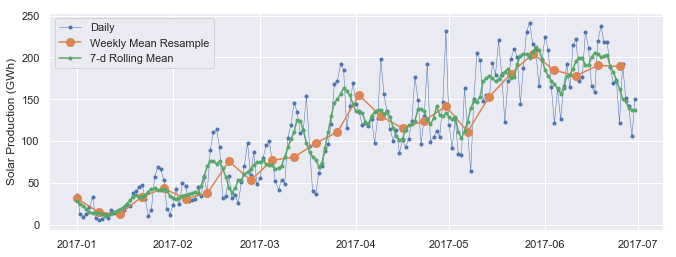

In this tutorial, we will learn about the powerful time series tools in the pandas library. And we’ll learn to make cool charts like this!    


Originally developed for financial time series such as daily stock market prices, the robust and flexible data structures in pandas can be applied to time series data in any domain, including business, science, engineering, public health, and many others. With these tools you can easily organize, transform, analyze, and visualize your data at any level of granularity — examining details during specific time periods of interest, and zooming out to explore variations on different time scales, such as monthly or annual aggregations, recurring patterns, and long-term trends.    


In the broadest definition, a time series is any data set where the values are measured at different points in time. Many time series are uniformly spaced at a specific frequency, for example, hourly weather measurements, daily counts of web site visits, or monthly sales totals. Time series can also be irregularly spaced and sporadic, for example, timestamped data in a computer system’s event log or a history of 911 emergency calls. Pandas time series tools apply equally well to either type of time series.    


This tutorial will focus mainly on the data wrangling and visualization aspects of time series analysis. Working with a time series of energy data, we’ll see how techniques such as time-based indexing, resampling, and rolling windows can help us explore variations in electricity demand and renewable energy supply over time. We’ll be covering the following topics:    


* The data set: Open Power Systems Data    
* Time series data structures    
* Time-based indexing    
* Visualizing time series data    
* Seasonality    
* Frequencies    
* Resampling    
* Rolling windows    
* Trends    


We’ll be using Python 3.6, pandas, matplotlib, and seaborn. To get the most out of this tutorial, you’ll want to be familiar with the basics of pandas and matplotlib.

##The data set: Open Power Systems Data    


In this tutorial, we’ll be working with daily time series of Open Power System Data (OPSD) [link text](https://open-power-system-data.org/) for Germany, which has been [rapidly expanding its renewable energy production in recent years](https://www.independent.co.uk/environment/renewable-energy-germany-six-months-year-solar-power-wind-farms-a8427356.html). The data set includes country-wide totals of electricity consumption, wind power production, and solar power production for 2006-2017. You can [download the data here](https://github.com/jenfly/opsd/raw/master/opsd_germany_daily.csv).    

*Alternatively, you may use the `!curl` statement which follows to create a local instance of the data file using Professor Patrick's GitHub repo.*    


Electricity production and consumption are reported as daily totals in gigawatt-hours (GWh). The columns of the data file are:    

* **Date** — The date (yyyy-mm-dd format)    
* **Consumption** — Electricity consumption in GWh    
* **Wind** — Wind power production in GWh    
* **Solar** — Solar power production in GWh    
* **Wind+Solar** — Sum of wind and solar power production in GWh    


We will explore how electricity consumption and production in Germany have varied over time, using pandas time series tools to answer questions such as:

* When is electricity consumption typically highest and lowest?    
* How do wind and solar power production vary with seasons of the year?    
* What are the long-term trends in electricity consumption, solar power, and wind power?    
* How do wind and solar power production compare with electricity consumption, and how has this ratio changed over time?    



In [8]:
!curl 'https://raw.githubusercontent.com/ProfessorPatrickSlatraigh/data/main/opsd_germany_daily.csv' -o opsd_germany_daily.csv   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  217k  100  217k    0     0   524k      0 --:--:-- --:--:-- --:--:--  524k


##Time series data structures    


Before we dive into the OPSD data, let’s briefly introduce the main pandas data structures for working with dates and times. In pandas, a single point in time is represented as a **Timestamp**. We can use the `to_datetime()` function to create `Timestamps` from strings in a wide variety of date/time formats. Let’s import pandas and convert a few dates and times to `Timestamps`.

In [2]:
import pandas as pd
pd.to_datetime('2018-01-15 3:45pm')

Timestamp('2018-01-15 15:45:00')

In [3]:
pd.to_datetime('7/8/1952')

Timestamp('1952-07-08 00:00:00')

As we can see, `to_datetime()` automatically infers a date/time format based on the input. In the example above, the ambiguous date '7/8/1952' is assumed to be *month/day/year* and is interpreted as July 8, 1952. Alternatively, we can use the `dayfirst` parameter to tell pandas to interpret the date as August 7, 1952.    



In [5]:
pd.to_datetime('7/8/1952', dayfirst=True)

Timestamp('1952-08-07 00:00:00')

*note: the original DataQuest tutorial has a typo and is missing the second quote in the snippet of code above.*

If we supply a list or array of strings as input to `to_datetime()`, it returns a sequence of *date/time* values in a **DatetimeIndex** object, which is the core data structure that powers much of pandas time series functionality.

In [6]:
pd.to_datetime(['2018-01-05', '7/8/1952', 'Oct 10, 1995'])

DatetimeIndex(['2018-01-05', '1952-07-08', '1995-10-10'], dtype='datetime64[ns]', freq=None)

In the **DatetimeIndex** above, the data type `datetime64[ns]` indicates that the underlying data is stored as 64-bit integers, in units of nanoseconds (ns). This data structure allows pandas to compactly store large sequences of *date/time* values and efficiently perform vectorized operations using **NumPy datetime64 arrays**.

If we’re dealing with a sequence of strings all in the same *date/time* format, we can explicitly specify it with the `format` parameter. For very large data sets, this can greatly speed up the performance of `to_datetime()` compared to the default behavior, where the format is inferred separately for each individual string. Any of the format codes from the `strftime()` and `strptime()` functions in Python’s built-in datetime module can be used. The example below uses the format codes `%m` (numeric month), `%d` (day of month), and `%y (2-digit year) to specify the format.

In [7]:
pd.to_datetime(['2/25/10', '8/6/17', '12/15/12'], format='%m/%d/%y')

DatetimeIndex(['2010-02-25', '2017-08-06', '2012-12-15'], dtype='datetime64[ns]', freq=None)

In addition to Timestamp and DatetimeIndex objects representing individual points in time, pandas also includes data structures representing durations (e.g., 125 seconds) and periods (e.g., the month of November 2018). For more about these data structures, there is a nice summary here. In this tutorial we will use DatetimeIndexes, the most common data structure for pandas time series.    


###Creating a time series DataFrame    

To work with time series data in pandas, we use a **DatetimeIndex** as the index for our DataFrame (or Series). Let’s see how to do this with our OPSD data set. First, we use the `read_csv()` function to read the data into a **DataFrame**, and then display its shape.

In [9]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv')
opsd_daily.shape

(4383, 5)

The **DataFrame** has 4383 rows, covering the period from January 1, 2006 through December 31, 2017. To see what the data looks like, let’s use the `head()` and `tail()` methods to display the first three and last three rows.

In [10]:
opsd_daily.head(3)

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN


In [11]:
opsd_daily.tail(3)

,Date,Consumption,Wind,Solar,Wind+Solar
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714
4382,2017-12-31,1107.11488,721.176,19.980,741.156


Next, let’s check out the data types of each column.    


In [12]:
opsd_daily.dtypes

Date            object
Consumption    float64
Wind           float64
Solar          float64
Wind+Solar     float64
dtype: object

Now that the `Date` column is the correct data type, let’s set it as the **DataFrame**’s index.

In [13]:
opsd_daily = opsd_daily.set_index('Date')
opsd_daily.head(3)

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.184,NaN,NaN,NaN
2006-01-02,1380.521,NaN,NaN,NaN
2006-01-03,1442.533,NaN,NaN,NaN


In [14]:
opsd_daily.index

Index(['2006-01-01', '2006-01-02', '2006-01-03', '2006-01-04', '2006-01-05',
       '2006-01-06', '2006-01-07', '2006-01-08', '2006-01-09', '2006-01-10',
       ...
       '2017-12-22', '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-26',
       '2017-12-27', '2017-12-28', '2017-12-29', '2017-12-30', '2017-12-31'],
      dtype='object', name='Date', length=4383)

Alternatively, we can consolidate the above steps into a single line, using the `index_col` and `parse_dates` parameters of the `read_csv()` function. This is often a useful shortcut.

In [15]:
opsd_daily = pd.read_csv('opsd_germany_daily.csv', index_col=0, parse_dates=True)

Now that our **DataFrame**’s index is a **DatetimeIndex**, we can use all of pandas’ powerful time-based indexing to wrangle and analyze our data, as we shall see in the following sections.

Another useful aspect of the **DatetimeIndex** is that the individual *date/time* components are all available as attributes such as `year`, `month`, `day`, and so on. Let’s add a few more columns to opsd_daily, containing the year, month, and weekday name.

In [17]:
# Add columns with year, month, and weekday name
opsd_daily['Year'] = opsd_daily.index.year
opsd_daily['Month'] = opsd_daily.index.month
# note: the DateTimeIndex has no attribute `weekday_name`
# opsd_daily['Weekday Name'] = opsd_daily.index.weekday_name
# Use `dayofweek` instead, which returns the ordinal day in the week
opsd_daily['Day of Week'] = opsd_daily.index.dayofweek
# Display a random sampling of 5 rows
opsd_daily.sample(5, random_state=0)

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Day of Week
Date,,,,,,,
2008-08-23,1152.011,NaN,NaN,NaN,2008,8,5
2013-08-08,1291.984,79.666,93.371,173.037,2013,8,3
2009-08-27,1281.057,NaN,NaN,NaN,2009,8,3
2015-10-02,1391.050,81.229,160.641,241.870,2015,10,4
2009-06-02,1201.522,NaN,NaN,NaN,2009,6,1


*errata in original tutorial*    


```
# note: the DateTimeIndex has no attribute `weekday_name`
# opsd_daily['Weekday Name'] = opsd_daily.index.weekday_name
# Use `dayofweek` instead, which returns the ordinal day in the week
opsd_daily['Day of Week'] = opsd_daily.index.dayofweek
```
    



### Time-based indexing    


One of the most powerful and convenient features of pandas time series is **time-based indexing** — using dates and times to intuitively organize and access our data. With **time-based indexing**, we can use *date/time* formatted strings to select data in our DataFrame with the `loc` accessor. The indexing works similar to standard label-based indexing with `loc`, but with a few additional features.

For example, we can select data for a single day using a string such as '2017-08-10'.

In [18]:
opsd_daily.loc['2017-08-10']

Consumption    1351.491
Wind            100.274
Solar            71.160
Wind+Solar      171.434
Year           2017.000
Month             8.000
Day of Week       3.000
Name: 2017-08-10 00:00:00, dtype: float64

We can also select a slice of days, such as `'2014-01-20':'2014-01-22'`. As with regular label-based indexing with `loc`, the slice is inclusive of both endpoints.

In [19]:
opsd_daily.loc['2014-01-20':'2014-01-22']

,Consumption,Wind,Solar,Wind+Solar,Year,Month,Day of Week
Date,,,,,,,
2014-01-20,1590.687,78.647,6.371,85.018,2014,1,0
2014-01-21,1624.806,15.643,5.835,21.478,2014,1,1
2014-01-22,1625.155,60.259,11.992,72.251,2014,1,2


Another very handy feature of pandas time series is **partial-string indexing**, where we can select all *date/times* which partially match a given string. For example, we can select the entire year 2006 with `opsd_daily.loc['2006']`, or the entire month of February 2012 with `opsd_daily.loc['2012-02']`.

In [ ]:
opsd_daily.loc['2006']

*note: added example mentioned in text but not provided in the tutorial.*

In [ ]:
opsd_daily.loc['2012-02']

##Visualizing time series data    


With `pandas` and `matplotlib`, we can easily visualize our time series data. In this section, we’ll cover a few examples and some useful customizations for our time series plots. First, let’s `import matplotlib`.

In [22]:
import matplotlib.pyplot as plt
# Display figures inline in Jupyter notebook

We’ll use Seaborn styling for our plots, and let’s adjust the default figure size to an appropriate shape for time series plots.

In [23]:
import seaborn as sns
# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

Let’s create a line plot of the full time series of Germany’s daily electricity consumption, using the **DataFrame**’s `plot()` method.

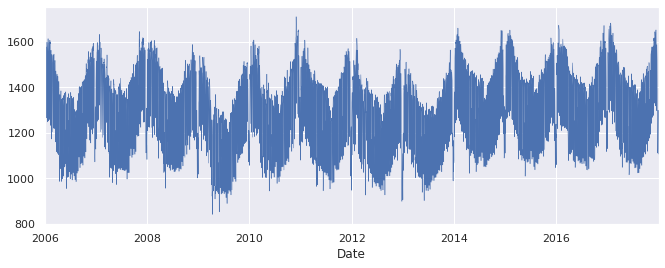

In [24]:
opsd_daily['Consumption'].plot(linewidth=0.5);

We can see that the `plot()` method has chosen pretty good tick locations (every two years) and labels (the years) for the x-axis, which is helpful. However, with so many data points, the line plot is crowded and hard to read. Let’s plot the data as dots instead, and also look at the **Solar** and **Wind** time series.

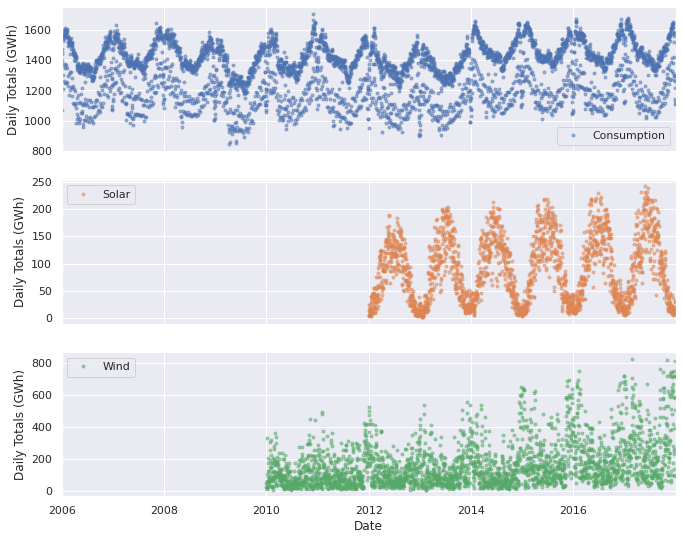

In [25]:
cols_plot = ['Consumption', 'Solar', 'Wind']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')
    

We can already see some interesting patterns emerge:

* Electricity consumption is highest in winter, presumably due to electric heating and increased lighting usage, and lowest in summer.    
* Electricity consumption appears to split into two clusters — one with oscillations centered roughly around 1400 GWh, and another with fewer and more scattered data points, centered roughly around 1150 GWh. We might guess that these clusters correspond with weekdays and weekends, and we will investigate this further shortly.    
* Solar power production is highest in summer, when sunlight is most abundant, and lowest in winter.   
* Wind power production is highest in winter, presumably due to stronger winds and more frequent storms, and lowest in summer.    


There appears to be a strong increasing trend in wind power production over the years.    


All three time series clearly exhibit periodicity—often referred to as seasonality in time series analysis—in which a pattern repeats again and again at regular time intervals. The Consumption, Solar, and Wind time series oscillate between high and low values on a yearly time scale, corresponding with the seasonal changes in weather over the year. However, seasonality in general does not have to correspond with the meteorological seasons. For example, retail sales data often exhibits yearly seasonality with increased sales in November and December, leading up to the holidays.    


Seasonality can also occur on other time scales. The plot above suggests there may be some weekly seasonality in Germany’s electricity consumption, corresponding with weekdays and weekends. Let’s plot the time series in a single year to investigate further.    



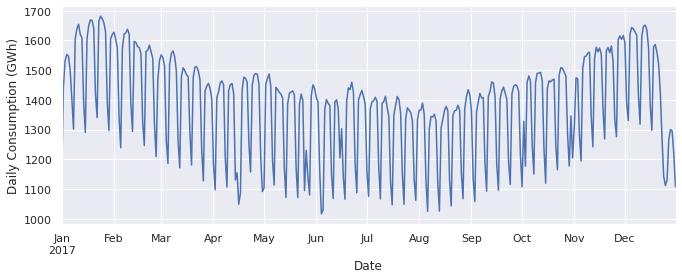

In [26]:
ax = opsd_daily.loc['2017', 'Consumption'].plot()
ax.set_ylabel('Daily Consumption (GWh)');

Now we can clearly see the weekly oscillations. Another interesting feature that becomes apparent at this level of granularity is the drastic decrease in electricity consumption in early January and late December, during the holidays.

Let’s zoom in further and look at just January and February.

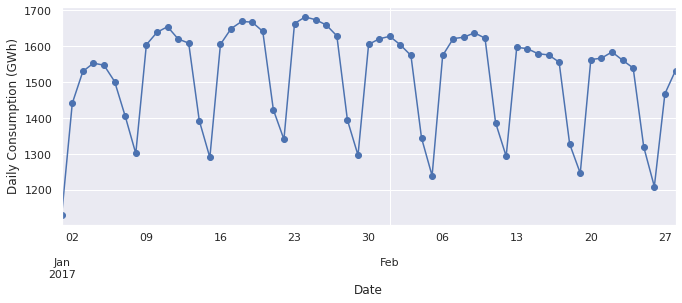

In [27]:
ax = opsd_daily.loc['2017-01':'2017-02', 'Consumption'].plot(marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)');

As we suspected, consumption is highest on weekdays and lowest on weekends.    


###Customizing time series plots    

To better visualize the weekly seasonality in electricity consumption in the plot above, it would be nice to have vertical gridlines on a weekly time scale (instead of on the first day of each month). We can customize our plot with `matplotlib.dates`, so let’s import that module.

In [28]:
import matplotlib.dates as mdates

Because date/time ticks are handled a bit differently in matplotlib.dates compared with the DataFrame’s `plot()` method, let’s create the plot directly in matplotlib. Then we use `mdates.WeekdayLocator()` and `mdates.MONDAY` to set the x-axis ticks to the first Monday of each week. We also use `mdates.DateFormatter()` to improve the formatting of the tick labels, using the **format codes** we saw earlier.

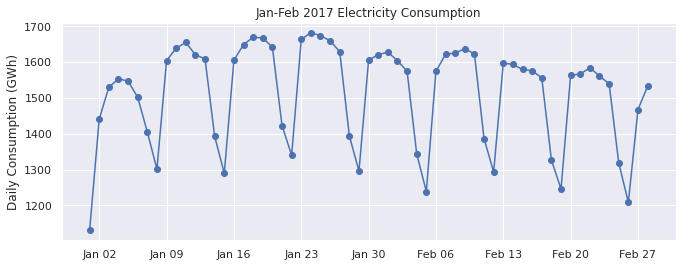

In [29]:
fig, ax = plt.subplots()
ax.plot(opsd_daily.loc['2017-01':'2017-02', 'Consumption'], marker='o', linestyle='-')
ax.set_ylabel('Daily Consumption (GWh)')
ax.set_title('Jan-Feb 2017 Electricity Consumption')
# Set x-axis major ticks to weekly interval, on Mondays
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
# Format x-tick labels as 3-letter month name and day number
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'));

*note: any **day of week** / **weekday** information is based on the ealier use of `dayofweek` ordinal not the incorrect `weekday_name` attribute presumed in the original tutorial.*